
# Optional Module 1, Practical 12

In this practical we will will see some other functionalities of Biopython. The content of this practical is **optional**!

## Biopython

From the Biopython tutorial: The Biopython Project is an international association of developers of freely available Python tools for computational molecular biology. The goal of Biopython is to make it as easy as possible to use Python for bioinformatics by creating high-quality, reusable modules and classes. Biopython features include parsers for various Bioinformatics file formats (BLAST, Clustalw, FASTA, Genbank,...), access to online services (NCBI, Expasy,...), interfaces to common and not-so-common programs (Clustalw, DSSP, MSMS...), a standard sequence class, various clustering modules, a KD tree data structure etc. and even some documentation :-).

In this practical we will see some features of Biopython but refer to [biopython documentation](http://biopython.org/wiki/Documentation) to discover all its features, recipes etc.

These notes are largely based on the tutorial that is available [here](http://biopython.org/DIST/docs/tutorial/Tutorial.pdf).



## BLAST

[Blast (Basic logical alignment search tool)](https://www.ncbi.nlm.nih.gov/pubmed/2231712) is a well known tool to find similarities between biological sequences. It compares DNA or protein sequences and calculates the statistical significance of the matches found.

The typical interaction with BLAST sees the user submit some sequences to the tool to get an alignment and then the hits are parsed to obtain information on the matches. Both these steps can be performed from within Biopython. Although it is possible to interact directly with a local installation of BLAST, in this practical we will work with the tool made available by NCBI (available [here](https://blast.ncbi.nlm.nih.gov/Blast.cgi)). Note that this might require a lot more computational time due to the delays of the network and traffic limitations.

### The function qblast

The online version of blast can be accessed through the ```Bio.Blast.NCBIWWW.qblast()``` function.

It's basic syntax is the following (first import ```from Bio.Blast import NCBIWWW```):

```
result_handle = Bio.Blast.NCBIWWW.qblast(blast_program, database, query_str)
```
where ```blast_program``` is the program to perform the alignment. The options are **blastn, blastp, blastx, tblast or tblastx**. ```database``` is the database to search against and ```query_str``` is a string containing the query to search against the database. The query can be a sequence or a fasta file entry or an identifier like a GI number (NCIBI's sequence identification number). Among the others, some optional parameters are the output format (```format_type``` that by default is "XML" which is the most stable output format but results can be stored also as text with "Text"). It is also possible to specify an expectation value cut-off to filter out alignments ```expect``` (the e-value threshold, default value is 10.0).

Some databases to search against are reported below:

![dbs](img/pract11/blast_dbs.png)

The query string can be obtained in different ways, for example it is possible to load sequences from a fasta file with:

```
from Bio.Blast import NCBIWWW
fasta_string = open("myfile.fasta").read()
result_handle = NCBIWWW.qblast("blastn", "nt", fasta_string)
```

or we can give a SeqRecord:

```
from Bio.Blast import NCBIWWW
from Bio import SeqIO
record = SeqIO.read("myfile.fasta", format="fasta")
result_handle = NCBIWWW.qblast("blastn", "nt", record.seq)
```

It is also possible to specify some optional parameters in the ```entrez_query``` for example we can limit the search to specific organisms with: ```entrez_query='"Malus Domestica" [Organism]'```.


**Example:** Let's align the first 100 bases of the first entry of the file [contigs82.fasta](file_samples/contigs82.fasta) to the Malus Domestica genome.

**NOTE: this can take several minutes.**

In [1]:
from Bio.Blast import NCBIWWW
from Bio import SeqIO



records = SeqIO.parse("file_samples/contigs82.fasta", format="fasta")
rec = next(records)
seq = rec.seq[0:100]
print("Aligning {} [{}] to Malus Dom.".format(rec.id,
                                              seq[0:10]+"..."+seq[90:101]))
result_handle = NCBIWWW.qblast("blastn", "nt", 
                               seq,
                               entrez_query='"Malus Domestica" [Organism]'
                              )

Aligning MDC020656.85 [GAGGGGTTTA...TTGGCAGCAA] to Malus Dom.


Note that the previous code does not output anything, it just returns a ```result_handle```. We need to parse it to get some results.

### Parsing qblast output

Once the qblast call returns, it gives the results in a handle object ```result_handle``` that we can parse or we can write to disk to avoid having to rerun the query other times. If we expect to get one alignment only, we can use the method **read** otherwise (if we have multiple query sequences) we should use the method **parse**: 

```
blast_record = NCBIXML.read(result_handle)
```

or 

```
blast_records = NCBIXML.parse(result_handle)
```
Note that to use these methods we first need to import the ```NCBIXML``` module with ```from Bio.Blast import NCBIXML```.

These methods are analogous to what seen in the case of SeqIO and AlignIO. In the case of multiple entries we can loop through them with:

```
blast_records = NCBIXML.parse(result_handle)
for record in blast_records:
    #do something with it...
    
```
or we can retrieve one record at a time with ```record = next(blast_records)```.


### Saving results to file

To save the results present in the result_handle we can simply write them to file. In case we have only one entry we can read it and write it to file:

```
out_f = open("my_blast_result.xml", "w")
out_f.write(result_handle.read())
out_f.close 
result_handle.close()
```
If we have more than one entry we need to loop through all the entries and save them in the file:

```
out_f = open("my_blast_result.xml", "w")
for entry in result_handle.parse():
    out_f.write(entry)
out_f.close 
result_handle.close()
```

**Example:**

Let's BLAST the galactosidase alpha (gi number: 2717) against the human database on NCBI and save the results to file. (**Note that it can take several seconds/minutes to run!**).

In [2]:
from Bio.Blast import NCBIWWW

result_handle = NCBIWWW.qblast("blastn", "nt", "2717")


with open("file_samples/blast_res.xml","w") as out_f:
    out_f.write(result_handle.read())

result_handle.close()

### Open a blast .XML file

A BLAST output file can be read by opening the file to get the handler and then parse it with the method **parse** seen above:

```
from Bio.Blast import NCBIXML
result_handle = open("my_blast.xml")
blast_records = NCBIXML.parse(result_handle)
```
This will end up in a handle to the blast results.


### The BLAST record class

The ```Bio.Blast.Record.Blast``` class holds the results of the alignment. In particular it is composed of the following three information:

1. *query*: the identifier of the query (a string).

2. *Descriptions* : a list of Description objects. Each ```Description``` holds the following information:

    - ```Description.title``` : a string with the title of the hit;
    - ```Description.score``` : a float with the score of the alignment;
    - ```Description.num_alignments``` : an int with the number of alignments with the same subject;
    - ```Description.e``` : a float with the e-value of the alignment.
    
3. *Alignments* : a list of Alignment objects. Each ```Alignment``` holds the following information:

    - ```Alignment.title``` : a string with the title of the hit (identical to ```Description.title```);
    - ```Alignment.length``` : an int with the length of the alignment;
    - ```Alignment.hsps``` : a list of HSP objects (High Scoring Pair). Each ```HSP``` has the following info:
        
        - ```HSP.score``` : the BLAST score of the hit
        - ```HSP.bits``` :  the bits score of the hit (x: on average 2^x pairs to find such a good hit by chance)
        - ```HSP.expect``` : the evalue of the hit
        - ```HSP.num_alignments``` : the number of alignments for the same subject
        - ```HSP.identities``` : the number of identities between query and subject
        - ```HSP.positives``` : the number of identical bases/aminos or having similar chemical properties
        - ```HSP.gaps``` : the number of gaps between query and subject
        - ```HSP.strand``` : a **tuple** with (query,subject) strands
        - ```HSP.frame``` : a **tuple** with the frame shifts
        - ```HSP.query/HSP.sbjct``` : query/subject sequence
        - ```HSP.query_start/HSP.sbjct_start``` :query/subject start point
        - ```HSP.match``` : the match sequence (basically "|" for matches and spaces for mismatches)
        - ```HSP.align_length``` : the alignment length.

More information on the BLAST record can be found [here](http://biopython.org/DIST/docs/api/Bio.Blast.Record-module.html).

**Example:**

Let's blast the serum albumin sequence (gi number [23307792](https://www.ncbi.nlm.nih.gov/nuccore/AF542069.1)) on the human genome and report all the information reported by BLAST. (warning: it might take a while to run!)

In [3]:
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML

result_handle = NCBIWWW.qblast("blastn", "nt", "23307792", 
                               entrez_query='"Homo Sapiens" [Organism]'
                               )



for res in NCBIXML.parse(result_handle):
    for d in res.descriptions:
        
        print("TITLE:{}\nSCORE:{}\nN.ALIGN:{}\nE-VAL:{}".format(
            d.title,d.score, d.num_alignments,d.e))
        
    for a in res.alignments:
        print("Align Title:{}\nAlign Len: {}".format(a.title, a.length))

        
    
        for h in a.hsps:
            s = h.score
            b = h.bits
            e = h.expect
            n = h.num_alignments
            i = h.identities
            p = h.positives
            g = h.gaps
            st = h.strand
            f = h.frame
            q = h.query
            sb = h.sbjct
            qs = h.query_start
            ss = h.sbjct_start
            qe = h.query_end
            se = h.sbjct_end
            m = h.match 
            al = h.align_length
            
            print("Score: {} Bits: {} E-val: {}".format(s,b,e))
            print("N.aligns:{} Ident:{} Pos.:{} Gaps:{} Align len:{}".format(
                n,i,p,g,al))
            print("Strand: {} Frame: {}".format(st,f))
            print("Query:", q, " start:", qs, " end:", qe)
            print("Match:",m)
            print("Subjc:",sb, " start:", ss, " end:", se)
            

result_handle.close()

TITLE:gi|23307792|gb|AF542069.1| Homo sapiens serum albumin (HSA) mRNA, complete cds
SCORE:4352.0
N.ALIGN:1
E-VAL:0.0
TITLE:gi|1519245814|ref|NM_000477.7| Homo sapiens albumin (ALB), mRNA
SCORE:4305.0
N.ALIGN:1
E-VAL:0.0
TITLE:gi|28591|emb|V00495.1| H.sapiens mRNA for serum albumin
SCORE:4253.0
N.ALIGN:2
E-VAL:0.0
TITLE:gi|7770116|gb|AF119840.1|AF119840 Homo sapiens PRO0903 mRNA, complete cds
SCORE:4062.0
N.ALIGN:1
E-VAL:0.0
TITLE:gi|25058738|gb|BC039235.1| Homo sapiens albumin, mRNA (cDNA clone IMAGE:4768004), containing frame-shift errors
SCORE:4056.0
N.ALIGN:1
E-VAL:0.0
TITLE:gi|23243417|gb|BC036003.1| Homo sapiens albumin, mRNA (cDNA clone MGC:32850 IMAGE:4724105), complete cds
SCORE:4052.0
N.ALIGN:1
E-VAL:0.0
TITLE:gi|158258946|dbj|AK292755.1| Homo sapiens cDNA FLJ78413 complete cds, highly similar to Homo sapiens albumin, mRNA
SCORE:4036.0
N.ALIGN:1
E-VAL:0.0
TITLE:gi|28589|emb|V00494.1| Human messenger RNA for serum albumin (HSA)
SCORE:4033.0
N.ALIGN:1
E-VAL:0.0
TITLE:gi|2170645

**Example:** Let's align the first 100 bases of the first 5 entries of the file [contigs82.fasta](file_samples/contigs82.fasta) to the Malus Domestica genome, writing the results to a apple_first5.xml file.
Sample output is here: [apple_first5.xml](file_samples/apple_first5.xml).
**NOTE: this can take several minutes.**

In [4]:
from Bio.Blast import NCBIWWW
from Bio import SeqIO

rc = SeqIO.parse("file_samples/contigs82.fasta", format="fasta")
fasta_string = ""
ids2align =[]
for i in range(5):
    entry = next(rc)
    fasta_string +=">" + entry.id +"\n"+entry.seq +"\n"
    ids2align.append(entry.id)
print("Aligning the following {} entries:\n\t{}".format(
                                                    len(ids2align),
                                                    "\n\t".join(ids2align)
                                                    ))
result_handle = NCBIWWW.qblast("blastn", "nt", 
                               fasta_string,
                               entrez_query='"Malus Domestica" [Organism]'
                              )

with open("file_samples/blast_res_apple.xml","w") as out_f:
    out_f.write(result_handle.read())
print("Output written to \"blast_res_apple.xml\"")

Aligning the following 5 entries:
	MDC020656.85
	MDC001115.177
	MDC013284.379
	MDC018185.243
	MDC018185.241
Output written to "blast_res_apple.xml"


## Getting data from NCBI

Biopython provides a module (```Bio.Entrez```) to pull data off resources like PubMed or GenBank, and other repositories programmatically through [Entrez](http://www.ncbi.nlm.nih.gov/Entrez/). 

There are some limitations (mostly taken care of directly by Biopython) that you should be aware of when you use NCBI's services (e.g. they recommend not to run more than 3 requests per second on weekdays, ...). Check [here](http://www.ncbi.nlm.nih.gov/books/NBK25497/#chapter2.Usage_Guidelines_and_Requiremen) if you want to learn what these limitations are.

First of all we need to import the Entrez module with (```from Bio import Entrez```) and then we can start interacting with Entrez, then we should specify (optional) an email setting ```Entrez.email``` (this is optional but you get a warning if you do not specify it -- the email would be used to notify the user in case of excessive usage).

In particular the module (complete info on [Entrez module are here](http://biopython.org/DIST/docs/api/Bio.Entrez-module.html)) provides, among the others, the following functions:

1. ```res_handle = Entrez.einfo(db)``` returns a summary of the Entez databases as a results handle. ```db``` is an optional parameter specifying the resource of interest;
2. ```res_handle = Entrez.esearch(db, term,id)``` returns all the entries in ```db``` having query matching the term ```term```. It is also possible to specify an ```id``` to get the information relative to that resource id;
3. ```res_handle = Entrez.efetch(db, id, rettype, retmode)``` returns full record corresponding to the identifier ``id`` from the database ``db`` formatted in ```rettype``` (eg. gb, fasta,... [complete list](https://www.ncbi.nlm.nih.gov/books/NBK25499/table/chapter4.T._valid_values_of__retmode_and/?report=objectonly)) and return mode ```retmode``` (eg. text); 
4. ```res_handle = Entrez.esummary(db, id)``` returns the summary of the entry ```id``` from the database ```db``` as a handle;
5. ```result = Entrez.read(res_handle)``` reads the information on the XML handle ```res_handle``` and stores them in a dictionary, list or string, depending on the case.  


**Example:**

Let's get a list of all available databases in Entrez as a dictionary. Let's then get a summary of the entries in 'sra'.

In [47]:
from Bio import Entrez
import datetime


Entrez.email = "my_email"
handle = Entrez.einfo()
res = Entrez.read(handle)
#print(res)
print("")
print("As a list:")
print(res['DbList'])

res = Entrez.read(Entrez.einfo(db = "sra"))
#uncomment to see all the information captured
#print(res)
#for el in res["DbInfo"].keys():
#    print(el) 
date = res["DbInfo"]["LastUpdate"]
dt = datetime.datetime.strptime(date, "%Y/%m/%d %H:%M")
print("")
print("Entries count: {:,}".format(int(res["DbInfo"]["Count"])))
print("LastUpdate: {}/{}/{} {}:{}".format(dt.day, 
                                          dt.month, 
                                          dt.year, 
                                          dt.hour,
                                          dt.minute))
print("Description:", res["DbInfo"]["Description"])





As a list:
['pubmed', 'protein', 'nuccore', 'ipg', 'nucleotide', 'structure', 'sparcle', 'protfam', 'genome', 'annotinfo', 'assembly', 'bioproject', 'biosample', 'blastdbinfo', 'books', 'cdd', 'clinvar', 'gap', 'gapplus', 'grasp', 'dbvar', 'gene', 'gds', 'geoprofiles', 'homologene', 'medgen', 'mesh', 'ncbisearch', 'nlmcatalog', 'omim', 'orgtrack', 'pmc', 'popset', 'proteinclusters', 'pcassay', 'biosystems', 'pccompound', 'pcsubstance', 'seqannot', 'snp', 'sra', 'taxonomy', 'biocollections', 'gtr']

Entries count: 12,222,409
LastUpdate: 27/10/2020 4:39
Description: SRA Database


Note that effectively **einfo** returned a handler to an object that can be read by the **read** function that produces a dictionary. This dictionary had one key only "DbList" that is the list of available databases in the first case, while the key when db was specified is "DbInfo".

**Example:**
Fetch the latest 10 entries (retmax = 10) in pubmed that are related to the species "Pyrus Communis" and report the title of the publication.

In [43]:
from Bio import Entrez

Entrez.email = "my_email"
handle = Entrez.esearch(db="pubmed", term="Pyrus communis", retmax = 10)
res = Entrez.read(handle)
for el in res.keys():
    print(el , " : ", res[el])

print("")
for ids in res["IdList"]:    
    print("Results for id:", ids)
    handle = Entrez.esummary(db="pubmed",  id = ids)
    res = Entrez.read(handle)
    #uncomment to see all info
    #print(res)
    for r in res:
        print(r["Title"])
        print("{}, {}".format(r['FullJournalName'],r['SO']))
        
    
        print("")


Count  :  356
RetMax  :  10
RetStart  :  0
IdList  :  ['33038244', '32992651', '32990517', '32972020', '32942590', '32899287', '32894061', '32889351', '32882874', '32849839']
TranslationSet  :  [{'From': 'Pyrus', 'To': '"pyrus"[MeSH Terms] OR "pyrus"[All Fields]'}]
TranslationStack  :  [{'Term': '"pyrus"[MeSH Terms]', 'Field': 'MeSH Terms', 'Count': '1092', 'Explode': 'Y'}, {'Term': '"pyrus"[All Fields]', 'Field': 'All Fields', 'Count': '1573', 'Explode': 'N'}, 'OR', 'GROUP', {'Term': 'communis[All Fields]', 'Field': 'All Fields', 'Count': '6139', 'Explode': 'N'}, 'AND', 'GROUP']
QueryTranslation  :  ("pyrus"[MeSH Terms] OR "pyrus"[All Fields]) AND communis[All Fields]

Results for id: 33038244
From the roots to the stem: unveiling pear root colonization and infection pathways by Erwinia amylovora.
FEMS microbiology ecology, 2020 Oct 10;

Results for id: 32992651
Bioactive Compounds and Health-Promoting Properties of Pear (<i>Pyrus communis</i> L.) Fruits.
Molecules (Basel, Switzerland

**Example:**
Retrieve genbank formatted information of the Malus x domestica MYB domain class transcription factor (MYB1) mRNA complete cds (nucleotide database id:HM122614.1). Parse it as a SeqRecord, printing only the sequence (remember previous practical's SeqIO).

In [7]:
from Bio import Entrez
from Bio import SeqIO

Entrez.email = "my_email"
handle = Entrez.efetch(db="nucleotide", 
                       id = "HM122614.1", 
                       rettype = "gb", 
                       retmode="text")
my_seq = SeqIO.read(handle, format = "genbank")
print(handle.read())
print(my_seq)
print("")
print("SEQUENCE:")
print(my_seq.seq)


ID: HM122614.1
Name: HM122614
Description: Malus x domestica MYB domain class transcription factor (MYB1) mRNA, complete cds
Number of features: 3
/molecule_type=mRNA
/topology=linear
/data_file_division=HTC
/date=15-AUG-2010
/accessions=['HM122614']
/sequence_version=1
/keywords=['HTC']
/source=Malus domestica (apple)
/organism=Malus domestica
/taxonomy=['Eukaryota', 'Viridiplantae', 'Streptophyta', 'Embryophyta', 'Tracheophyta', 'Spermatophyta', 'Magnoliopsida', 'eudicotyledons', 'Gunneridae', 'Pentapetalae', 'rosids', 'fabids', 'Rosales', 'Rosaceae', 'Amygdaloideae', 'Maleae', 'Malus']
/references=[Reference(title='Transcription Factors in Apple', ...), Reference(title='The FruiTFul database; full length cDNAs of apple transcription factors', ...), Reference(title='Direct Submission', ...)]
Seq('TTTGGTCTGCTGGGTAGGTACTCATAAAAACAAACCAACCGAAGCCTCCGAACC...AAA')

SEQUENCE:
TTTGGTCTGCTGGGTAGGTACTCATAAAAACAAACCAACCGAAGCCTCCGAACCGACCACCAATGACGGCCCCAAACGGCGCCGTCCCCAAACAAGCCGACGACCGCCCCGGCAC

## Getting data from ExPASy

Similarly to what done with Entrez, it is possible to pull data out of ExPASy (https://www.expasy.org/) through the Bio.ExPASy module. We will not cover this in detail. All information can be found here: [Bio.ExPASy module](http://biopython.org/DIST/docs/api/Bio.ExPASy-module.html#__package__).

As an example, we will see how to download a couple of SwissProt entries (the human, rhesus macaque and mouse P53 protein) and perform pairwise sequence alignment of Human vs Macaque and Human vs Mouse.

In [8]:
from Bio import ExPASy
from Bio import SwissProt
from Bio import pairwise2

#the ids of the human, rhesus and mouse proteins
accessions = ["P04637", "P56424", "P02340"] 
sequences = []
for accession in accessions:
    handle = ExPASy.get_sprot_raw(accession)
    record = SwissProt.read(handle)
    print("Organism: {}".format(record.organism))
    print(record.entry_name)
    print(",".join(record.accessions))
    print(record.keywords)
    
    print(record.sequence[:30] + "...")
    sequences.append(record.sequence)

print("\n\nPairwise sequence alignment of Human vs Rhesus P53:")

aligns = pairwise2.align.globalxx(sequences[0],sequences[1])
for al in aligns[0:3]:
    print("Score {}:".format(al[2]))
    print(al[0][0:50])
    print(al[1][0:50])
    
print("\n\nPairwise sequence alignment of Human vs Mouse P53:")

aligns = pairwise2.align.globalxx(sequences[0],sequences[2])
for al in aligns[0:3]:
    print("Score {}:".format(al[2]))
    print(al[0][0:50])
    print(al[1][0:50])    

Organism: Homo sapiens (Human).
P53_HUMAN
P04637,Q15086,Q15087,Q15088,Q16535,Q16807,Q16808,Q16809,Q16810,Q16811,Q16848,Q2XN98,Q3LRW1,Q3LRW2,Q3LRW3,Q3LRW4,Q3LRW5,Q86UG1,Q8J016,Q99659,Q9BTM4,Q9HAQ8,Q9NP68,Q9NPJ2,Q9NZD0,Q9UBI2,Q9UQ61
['3D-structure', 'Acetylation', 'Activator', 'Alternative promoter usage', 'Alternative splicing', 'Apoptosis', 'Biological rhythms', 'Cell cycle', 'Cytoplasm', 'Cytoskeleton', 'Direct protein sequencing', 'Disease mutation', 'DNA-binding', 'Endoplasmic reticulum', 'Glycoprotein', 'Host-virus interaction', 'Isopeptide bond', 'Li-Fraumeni syndrome', 'Metal-binding', 'Methylation', 'Mitochondrion', 'Necrosis', 'Nucleus', 'Phosphoprotein', 'Polymorphism', 'Reference proteome', 'Repressor', 'Transcription', 'Transcription regulation', 'Tumor suppressor', 'Ubl conjugation', 'Zinc']
MEEPQSDPSVEPPLSQETFSDLWKLLPENN...
Organism: Macaca mulatta (Rhesus macaque).
P53_MACMU
P56424
['Acetylation', 'Activator', 'Apoptosis', 'Biological rhythms', 'Cell cycle', 'Cytoplasm', 

You can find [here](http://biopython.org/DIST/docs/api/toc-Bio.SeqRecord-module.html) all the details on how to deal with the SwissProt records.

## 3D structure and PDB

Biopython can also deal with data coming from the [Protein Data Bank database](https://www.rcsb.org/pdb/home/home.do). It is a database of structural information of 3D shapes of proteins, nucleic acids, and complex assemblies. The database currently contains more than 157,000 total structures.

To deal with this kind of data we first need to import Biopython's module ```Bio.PDB``` with ```from Bio.PDB import *```. All the information on this module can be found [here](http://biopython.org/DIST/docs/api/Bio.PDB-module.html#__package__). 

It is possible to download a structure directly from PDB by using a ```PDBList``` object that features a function called ```download_pdb_files``` having the basic syntax:

```
PDBList.download_pdb_files(pdb_codes, pdir, file_format)

```
that downloads the ```file_format``` formatted structures defined in the ```pdb_codes``` list of 4 symbols structure Ids from PDB, stores them in the directory ```pdir```. The safer ```file_format``` to use is "mmCif". The function will not download the structures more than once. If a file is already present in the specified directory, a message **Structure exists** will be displayed. 

**Example:**

Let's programmatically download two different structures of the DNA polymerase [3C2K](https://www.rcsb.org/pdb/explore/explore.do?structureId=3C2K) and [3C2L](https://www.rcsb.org/pdb/explore/explore.do?structureId=3C2L)

In [9]:
from Bio.PDB import *

pdbl = PDBList()
structures = ["3C2K", "3C2L"]
el = pdbl.download_pdb_files(structures, 
                             file_format = "mmCif", 
                             pdir = "file_samples/")


Macromolecular Crystallographic Information Files (mmCif files .cif) is a paired collection of names (starting with "\_") and values.They also contain a description of the 3D placement of every crystalized atom of the structure. A detailed description of the format can be found [here](http://mmcif.wwpdb.org/docs/tutorials/mechanics/pdbx-mmcif-syntax.html).  

Once the structures are available locally, one can start parsing them to do something useful.
Parsing can be done through the ```MMCIFParser``` object:

```
parser = MMCIFParser()
```

The ```parser``` object has several methods able to deal with structures. One of these is the ```get_structure``` that creates a ```PDB.Structure.Structure``` object with all the data present in the structure file.

The basic syntax is:
```
structure = parser.get_structure(pdb_code, filename)
```

where ```pdb_code``` is the PDB code of the structure contained in the file ```filename```. The method returns a ```PDB.Structure.Structure``` that contains one or more models.  


A ```Structure``` consists of a collection of one or more ```Model``` (different 3D conformations of the very same structure) that is a collection of ```Chain``` that is a collection of ```Residues``` that is a collection of ```Atoms```. Look in the documentation to get the information on each of these classes. This is the diagram of a structure:

![structure](img/pract11/structure1.png)

Given a ```Structure``` we can obtain iterators to **models**, **chains**, **residues** or **atoms** with:

```
Structure.get_models() 
Structure.get_chains()
Structure.get_residues()
Structure.get_atoms()
```

For each model obtained with ```structure.get_models()``` function we can loop through its chains, residues and atoms. For atoms we can get the 3D coordinates with ```Atom.get_coord()```.

**Example:**
Let's loop through all the models, chain, residues and atoms of the DNA polymerase structure 3C2K. Print the 3D coordinates of each atom.

In [10]:
from Bio.PDB import *


parser = MMCIFParser(QUIET=True) #To disable warnings


filename = "file_samples/3c2l.cif"
structure = parser.get_structure("3c2l", filename)

for model in structure.get_models():
    print("model", model, "has {} chains".format(len(model)))
    
    for chain in model:
        print(" - chain ", chain, "has {} residues".format(len(chain)))
        
        for residue in chain:
            print ("      - residue", residue.get_resname(), "has {} atoms".format(len(residue)))
            
            for atom in residue:
                x,y,z = atom.get_coord()
                print("        - atom:", atom.get_name(), "x: {} y:{} z:{}".format(x,y,z))
                
                

model <Model id=0> has 4 chains
 - chain  <Chain id=T> has 41 residues
      - residue DC has 16 atoms
        - atom: O5' x: 30.740999221801758 y:-2.2209999561309814 z:16.618999481201172
        - atom: C5' x: 31.167999267578125 y:-0.9599999785423279 z:16.062999725341797
        - atom: C4' x: 29.996000289916992 y:-0.009999999776482582 z:15.932999610900879
        - atom: O4' x: 28.96299934387207 y:-0.6069999933242798 z:15.107000350952148
        - atom: C3' x: 29.320999145507812 y:0.38499999046325684 z:17.253000259399414
        - atom: O3' x: 29.166000366210938 y:1.8140000104904175 z:17.327999114990234
        - atom: C2' x: 27.96500015258789 y:-0.3019999861717224 z:17.187999725341797
        - atom: C1' x: 27.701000213623047 y:-0.3490000069141388 z:15.692000389099121
        - atom: N1 x: 26.76099967956543 y:-1.4010000228881836 z:15.24899959564209
        - atom: C2 x: 25.65999984741211 y:-1.034000039100647 z:14.456999778747559
        - atom: O2 x: 25.51300048828125 y:0.1620000004

        - atom: N x: 19.43400001525879 y:-3.8239998817443848 z:47.11199951171875
        - atom: CA x: 18.676000595092773 y:-4.2210001945495605 z:45.930999755859375
        - atom: C x: 17.445999145507812 y:-4.991000175476074 z:46.375999450683594
        - atom: O x: 16.354000091552734 y:-4.8429999351501465 z:45.827999114990234
        - atom: CB x: 19.527999877929688 y:-5.125999927520752 z:45.04399871826172
        - atom: OG x: 20.857999801635742 y:-4.6479997634887695 z:44.95500183105469
      - residue SER has 6 atoms
        - atom: N x: 17.650999069213867 y:-5.809000015258789 z:47.39699935913086
        - atom: CA x: 16.614999771118164 y:-6.6579999923706055 z:47.946998596191406
        - atom: C x: 15.543000221252441 y:-5.864999771118164 z:48.672000885009766
        - atom: O x: 14.366999626159668 y:-6.239999771118164 z:48.676998138427734
        - atom: CB x: 17.256999969482422 y:-7.659999847412109 z:48.895999908447266
        - atom: OG x: 16.29199981689453 y:-8.527000427246094 

        - atom: O x: -13.451000213623047 y:8.435999870300293 z:29.905000686645508
        - atom: CB x: -15.355999946594238 y:8.258999824523926 z:32.018001556396484
        - atom: CG x: -16.48200035095215 y:8.942999839782715 z:31.2450008392334
        - atom: CD1 x: -17.711000442504883 y:8.062999725341797 z:31.25
        - atom: CD2 x: -16.80299949645996 y:10.270000457763672 z:31.878000259399414
      - residue ILE has 8 atoms
        - atom: N x: -14.506999969482422 y:6.693999767303467 z:28.940000534057617
        - atom: CA x: -14.029000282287598 y:7.00600004196167 z:27.59600067138672
        - atom: C x: -15.149999618530273 y:7.5229997634887695 z:26.711000442504883
        - atom: O x: -16.299999237060547 y:7.142000198364258 z:26.871999740600586
        - atom: CB x: -13.437999725341797 y:5.7779998779296875 z:26.885000228881836
        - atom: CG1 x: -14.513999938964844 y:4.703999996185303 z:26.7549991607666
        - atom: CG2 x: -12.199999809265137 y:5.271999835968018 z:27.624000

Once we have the coordinates of an atom we can compute distances between atoms or angles. We can also align two structures rototranslating the two to minimize their distance. We will not cover this and many other features that are provided by Biopython, such as Pyhlogentic analysis tools, interface towards pathways in KEGG, clustering, etc. If you are interested, you can read about all the features available in the [Biopython tutorial](http://biopython.org/DIST/docs/tutorial/Tutorial.pdf).

## Exercises


1. Write a python script that retrieves all the information present in SRA regarding PacBio sequencing performed on E.coli strain K12 (query term is "E.coli K12 wgs PacBio"). Print the number of results and for each id report the title, the accession id, the total number of spots and total number of bases sequenced. 

Sample output: 
```
Entries found: 11
Results for id: 9966072
WGS of E. coli K12 with PacBio HiFi
 - acc="SRR10971019"
 - total_spots="95514"
 - total_bases="1389500381"
Results for id: 6705337
PacBio RSII sequencing of E. coli K12
 - acc="SRR8154667"
 - total_spots="163482"
 - total_bases="1561717136"
Results for id: 6705336
PacBio RSII sequencing of E. coli K12
 - acc="SRR8154668"
 - total_spots="163482"
 - total_bases="897324802"
 ...
 ...
```

<div class="tggle" onclick="toggleVisibility('ex1');">Show/Hide Solution</div>
<div id="ex1" style="display:none;">

In [12]:
%reset -s -f

from Bio import Entrez

Entrez.email = "my_email"
handle = Entrez.esearch(db="sra", term="E.coli K12 wgs PacBio", retmax = 100)
res = Entrez.read(handle)
#uncomment to see all fields:
#for el in res.keys():
#    print(el , " : ", res[el])
print("Entries found: {}".format(res["Count"]))


for ids in res["IdList"]:    
    print("Results for id:", ids)
    handle = Entrez.esummary(db="sra",  id = ids)
    res = Entrez.read(handle)
    #uncomment to see all info
    #print(res)
    for r in res:
        #print(r)
        info = r['ExpXml']
        #print(info)
        runs = r['Runs']
        #some text parsing to do:
        title = info.split("Title>")
        #print(title)
        print(title[1][:-2])
        #print(runs)
        r = runs.split(" ")
        #print(r)
        print(" - {}\n - {}\n - {}".format(r[1],
                                           r[2],
                                           r[3]))

Entries found: 11
Results for id: 9966072
WGS of E. coli K12 with PacBio HiFi
 - acc="SRR10971019"
 - total_spots="95514"
 - total_bases="1389500381"
Results for id: 6705337
PacBio RSII sequencing of E. coli K12
 - acc="SRR8154667"
 - total_spots="163482"
 - total_bases="1561717136"
Results for id: 6705336
PacBio RSII sequencing of E. coli K12
 - acc="SRR8154668"
 - total_spots="163482"
 - total_bases="897324802"
Results for id: 6705335
PacBio RSII sequencing of E. coli K12
 - acc="SRR8154669"
 - total_spots="163482"
 - total_bases="1570240924"
Results for id: 6705329
PacBio RSII sequencing of E. coli K12
 - acc="SRR8154675"
 - total_spots="163482"
 - total_bases="1765639407"
Results for id: 357838
E. coli K12 PacBio RS C2 CCS sequencing
 - acc="SRR801672"
 - total_spots="81741"
 - total_bases="247537688"
Results for id: 357018
E. coli K12 MG1655 PacBio RS C2 Sequencing
 - acc="SRR801649"
 - total_spots="81741"
 - total_bases="150361802"
Results for id: 357016
E. Coli K12 454 Sequencin

</div>

2. Write a python function that reads all the entries of a blast alignment file in .xml format (like [blast_res_apple.xml](file_samples/blast_res_apple.xml) and outputs all the HSPs (see example below) having bitscore > B, alignment length >  A and minimum percentage of identity > I, where B, A and I are input thresholds. Hint: implement a filtering function: *filterHSPs(align, minBitscore = 0, minAlignLen = 0, minPercIdent = 0.1)*.

```
Alignments of MDC020656.85
	MDC020656.85: 1939-2593
	gi|125995253|dbj|AB270792.1|: 201263-201917
	Score:820.917 AlignLen:579 Id/Len:0.8812785388127854
	MDC020656.85: 1446-1935
	gi|125995253|dbj|AB270792.1|: 306490-306017
	Score:582.873 AlignLen:428 Id/Len:0.8629032258064516
    ....
    ....
```

that is reporting the HSP with query start-end position, subject start-end position, score, alignment length and number of identities / alignment length. 

<div class="tggle" onclick="toggleVisibility('ex2');">Show/Hide Solution</div>
<div id="ex2" style="display:none;">

In [12]:
%reset -s -f

from Bio.Blast import NCBIXML


def filterHSPs(align, minBitscore = 0, minAlignLen = 0, minPercIdent = 0.1):
    ret = []

    for h in align.hsps:
            b = h.bits
            i = h.identities 
            al = h.align_length
            toOut = ((b > minBitscore) and 
                    (al > minAlignLen) and
                    (i/al > minPercIdent))

            
            
            if(toOut):
                qs = h.query_start
                ss = h.sbjct_start
                qe = h.query_end
                se = h.sbjct_end
                ret.append([qs,qe, ss,se, b, i, al])
             
    return ret        

result_handle = open("file_samples/blast_res_apple.xml")


for res in NCBIXML.parse(result_handle):
    print("Alignments of {}".format(res.query))
    for align in res.alignments:
        filtered = filterHSPs(align, 300, 50, 0.8)
        if(len(filtered) > 0):
            for h in filtered:
                title = align.title.split( )[0]
                print("\t{}: {}-{}".format(res.query,h[0],h[1]))
                print("\t{}: {}-{}".format(title,h[2],h[3]))
                print("\tScore:{} AlignLen:{} Id/Len:{}".format(
                                                                h[4],
                                                                h[5],
                                                                h[5]/h[6]
                                                               ))
            
    

            

result_handle.close()

Alignments of MDC020656.85
	MDC020656.85: 1939-2593
	gi|125995253|dbj|AB270792.1|: 201263-201917
	Score:820.917 AlignLen:579 Id/Len:0.8812785388127854
	MDC020656.85: 1446-1935
	gi|125995253|dbj|AB270792.1|: 306490-306017
	Score:582.873 AlignLen:428 Id/Len:0.8629032258064516
	MDC020656.85: 1447-1935
	gi|125995253|dbj|AB270792.1|: 202375-202869
	Score:543.199 AlignLen:424 Id/Len:0.848
	MDC020656.85: 1031-1475
	gi|125995253|dbj|AB270792.1|: 201861-202300
	Score:417.864 AlignLen:370 Id/Len:0.8078602620087336
Alignments of MDC001115.177
	MDC001115.177: 93-1292
	gi|125995253|dbj|AB270792.1|: 116873-118061
	Score:1196.92 AlignLen:1007 Id/Len:0.8186991869918699
	MDC001115.177: 2777-3118
	gi|125995253|dbj|AB270792.1|: 124753-125093
	Score:419.668 AlignLen:301 Id/Len:0.8775510204081632
Alignments of MDC013284.379
	MDC013284.379: 821-1195
	gi|1632177573|ref|XM_008340665.3|: 1263-1637
	Score:677.55 AlignLen:375 Id/Len:1.0
	MDC013284.379: 450-723
	gi|1632177573|ref|XM_008340665.3|: 994-1267
	Score:

</div>

3. Write a python function ```retrieve_sequences(search_term, number, outfile)``` that retrieves the first ```number``` of sequences from NCBI's "nucleotide" database having a search  term  ```term``` (hint: use term and retmax parameters of Entrez.esearch) and stores them in a fasta file ```outfile``` (hint: use SeqIO.write). Test your code retrieving the first 5 entries having search term "starch AND Malus Domestica [Organism]"

<div class="tggle" onclick="toggleVisibility('ex3');">Show/Hide Solution</div>
<div id="ex3" style="display:none;">

In [13]:
%reset -s -f

from Bio import Entrez
from Bio import SeqIO

def retrieve_sequences(search_term, number, filename):
    Entrez.email = "my_email"
    handle = Entrez.esearch(db="nucleotide", 
                            term=search_term, 
                            retmax=5)
    res = Entrez.read(handle)
    records = []
    for el in res["IdList"]:
        handle = Entrez.efetch(db="nucleotide", 
                               id=el, 
                               rettype = "gb", 
                               retmode="text")
        my_seq = SeqIO.read(handle, format = "genbank")
        records.append(my_seq)
    N = SeqIO.write(records, filename, "fasta")
    print("Search term was: ", search_term)
    print("{} sequences written to {}".format(N,filename))
    
s_term = "starch AND Malus Domestica [Organism]"
retrieve_sequences(s_term, 5, "file_samples/starch_sequences.fasta")


Search term was:  starch AND Malus Domestica [Organism]
5 sequences written to file_samples/starch_sequences.fasta


</div>

4. Write a python function that aligns the sequences  in the file created in exercise 3. ([here](file_samples/starch_sequences.fasta) you can find mine) against the NCBI nr database limiting the hits to the Malus Domestica organism (parameter entrez_query='"Malus Domestica" [Organism]' in qblast)and prints to screen the following info for each hsp: 
    1. The title;
    2. Score and e-value;
    3. The number of alignments on the same subject, the number of identities and positives and the alignment length;
    4. The number of mismatches and the list of their positions (hint: you can use the match string and look for " ").
   
<div class="tggle" onclick="toggleVisibility('ex4');">Show/Hide Solution</div>
<div id="ex4" style="display:none;">

In [ ]:
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML

fasta_string = open("file_samples/starch_sequences.fasta").read()

res_handle = NCBIWWW.qblast("blastn", "nt", fasta_string, 
                            entrez_query='"Malus Domestica" [Organism]'
                           )

for align in NCBIXML.parse(res_handle):
    
    for a in align.alignments:
            print("Align Title:{}".format(a.title))
            
            for h in a.hsps:
                s = h.score
                e = h.expect
                n = h.num_alignments
                i = h.identities
                p = h.positives
                m = h.match 
                al = h.align_length
                misM = [str(x) for x in range(len(m)) if m[x] == " "]
                print("Score: {} E-val: {}".format(s,e))
                print("N.aligns:{} Ident:{} Pos.:{} Align len:{}".format(
                    n,i,p,al))
                if(len(misM)):
                    print("Num mismatches:",len(misM))
                    print("Mismatch pos:", ",".join(misM))
                else:
                    print("No mismatches")
                print("")
            

res_handle.close()

</div>

</div>
5. Write a python function ```getPublicationInfo(title_term,other_term)``` that retrieves the first 20 pubmed publications having the ```title_term``` in the title and ```other_term``` somewhere else in the text (hint use: "Title" and "[Other Term]" as esearch parameter term). For each publication print: 
    1. the title
    2. authors 
    3. journal 
    4. year of publication (hint: get and split properly the "PubDate" entry)
    5. a link to the pubmed entry (hint: it is the string "https://www.ncbi.nlm.nih.gov/pubmed/" followed by the pubmed id ("eid" entry of the dictionary "ArticleIds"). es: https://www.ncbi.nlm.nih.gov/pubmed/26919684

Hint: to see how to combine search terms test them here: [https://www.ncbi.nlm.nih.gov/pubmed/advanced](https://www.ncbi.nlm.nih.gov/pubmed/advanced).

Test your code calling ```getPublicationInfo("apple","drought")```

<div class="tggle" onclick="toggleVisibility('ex5');">Show/Hide Solution</div>
<div id="ex5" style="display:none;">

In [15]:

from Bio import Entrez

def getPublicationInfo(title_term,other_term): 
    Entrez.email = "my_email"
    s_term = title_term + " [Title] AND " + other_term + " [Other Term]"
    handle = Entrez.esearch(db="pubmed", term=s_term)
    res = Entrez.read(handle)
#uncomment to see all info
#    for el in res.keys():
#        print(el , " : ", res[el])
#
#    print("")
    for ids in res["IdList"]:    
        handle = Entrez.esummary(db="pubmed",  id = ids)
        res = Entrez.read(handle)
        #uncomment to see all info
        #print(res)
        for r in res:
            print(r["Title"])
            print(",".join(r["AuthorList"]))
            print(r["Source"])
            print(r["PubDate"].split()[0])
            print("https://www.ncbi.nlm.nih.gov/pubmed/" + r["ArticleIds"]["eid"])
            print("")
            
getPublicationInfo("apple","drought")

Overexpression of MdIAA24 improves apple drought resistance by positively regulating strigolactone biosynthesis and mycorrhization.
Huang D,Wang Q,Jing G,Ma M,Li C,Ma F
Tree Physiol
2020
https://www.ncbi.nlm.nih.gov/pubmed/32856070

Genome-wide analysis of the light-harvesting chlorophyll a/b-binding gene family in apple (Malus domestica) and functional characterization of MdLhcb4.3, which confers tolerance to drought and osmotic stress.
Zhao S,Gao H,Luo J,Wang H,Dong Q,Wang Y,Yang K,Mao K,Ma F
Plant Physiol Biochem
2020
https://www.ncbi.nlm.nih.gov/pubmed/32688296

Regulation of phenylpropanoid biosynthesis by MdMYB88 and MdMYB124 contributes to pathogen and drought resistance in apple.
Geng D,Shen X,Xie Y,Yang Y,Bian R,Gao Y,Li P,Sun L,Feng H,Ma F,Guan Q
Hortic Res
2020
https://www.ncbi.nlm.nih.gov/pubmed/32637130

Apple SERRATE negatively mediates drought resistance by regulating MdMYB88 and MdMYB124 and microRNA biogenesis.
Li X,Chen P,Xie Y,Yan Y,Wang L,Dang H,Zhang J,Xu L,Ma F,Gu

</div>

6. Write some python code to retrieve the structure of two forms of the aspartate transcarbamoylase (PDB ids: 4FYW and 1D09). If you are interested, read more about the Aspartate Transcarbamoylase [here](http://pdb101.rcsb.org/motm/215). Write a function that gets the .cif file name and prints:

    1. the number of chains, residues and atoms present in the file;
    2. a histogram of the residues (plotting it with matplotlib) that are not water (encoded as "HOH");
    3. a link to an online tool to visualize the 3D structure. The link will be "http://www.rcsb.org/pdb/ngl/ngl.do?pdbid=" followed by the PDB id of the protein (e.g. 1d09).

<div class="tggle" onclick="toggleVisibility('ex6');">Show/Hide Solution</div>
<div id="ex6" style="display:none;">

Structure exists: 'file_samples/1d09.cif' 
Structure exists: 'file_samples/4fyw.cif' 


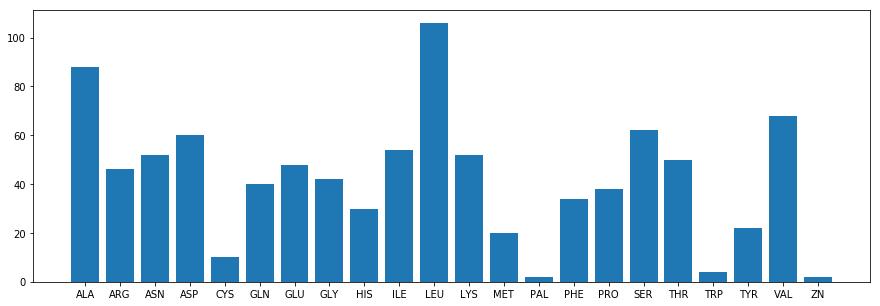

Number of chains: 4
Number of residues: 1547
Number of atoms: 7883
http://www.rcsb.org/pdb/ngl/ngl.do?pdbid=1d09


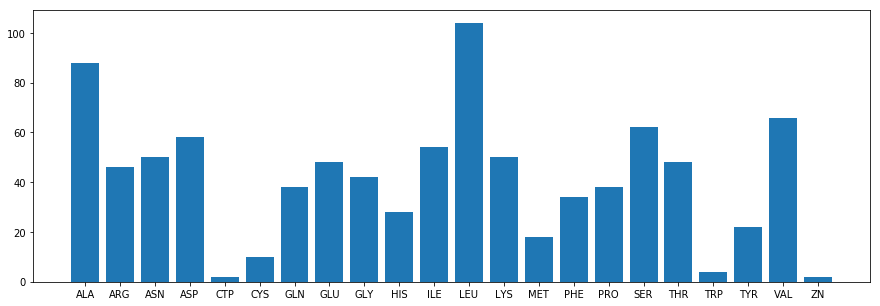

Number of chains: 4
Number of residues: 1483
Number of atoms: 7714
http://www.rcsb.org/pdb/ngl/ngl.do?pdbid=4fyw


In [13]:
from Bio.PDB import *
import matplotlib.pyplot as plt

def printCifInfo(filename):
    
    parser = MMCIFParser(QUIET=True) #To disable warnings
    id = filename.split("/")[1].split(".")[0]

    structure = parser.get_structure(id, filename)
    chains = structure.get_chains()
    residues = structure.get_residues()
    
    atoms = structure.get_atoms()
    res_histo = {}
    resCnt = 0 #need this because while reading the residues 
               #I am pulling stuff out of the iterator
    for res in residues:
        rname = res.get_resname()
        if(rname != "HOH"):
            if( rname not in res_histo):
                res_histo[rname] = 1
            else:
                res_histo[rname] += 1
        resCnt += 1    
    plt.figure(figsize=(15,5))
    plt.bar(res_histo.keys(), res_histo.values())
    plt.show()
    print("Number of chains: {}".format(len(list(chains))))
    print("Number of residues: {}".format(resCnt))
    print("Number of atoms: {}".format(len(list(atoms))))
    print("http://www.rcsb.org/pdb/ngl/ngl.do?pdbid=" + id) 

pdbl = PDBList()
structures = ["1D09", "4FYW"]
el = pdbl.download_pdb_files(structures, file_format = "mmCif", pdir = "file_samples/")

printCifInfo("file_samples/1d09.cif")
printCifInfo("file_samples/4fyw.cif")

</div>